**Importation des modeles**

In [ ]:

# Importation des bibliothèques
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.utils import to_categorical


**Paramètres audio**

In [ ]:
SAMPLE_RATE = 22050  # Fréquence d'échantillonnage
N_MFCC = 40  # Nombre de coefficients MFCC
MAX_PAD_LENGTH = 100  # Longueur maximale du spectrogramme

**Montage de Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "drive/MyDrive/dataset"

Mounted at /content/drive


**Fonction pour extraire les MFCC**

In [ ]:
import librosa
import numpy as np

SAMPLE_RATE = 22050
N_MFCC = 40
MAX_PAD_LENGTH = 100

def extract_mfcc(file_path, max_pad_length=MAX_PAD_LENGTH):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    except Exception as e:
        print(f"Erreur fichier {file_path}: {e}")
        return None

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.concatenate((mfcc, delta, delta2))
    features = (features - np.mean(features)) / np.std(features)
    features = librosa.util.fix_length(features, size=max_pad_length, axis=1)

    return features


In [ ]:
import os
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_data(data_path):
    labels = os.listdir(data_path)
    label_map = {label: i for i, label in enumerate(labels)}
    X, y = [], []

    for label in labels:
        files = os.listdir(os.path.join(data_path, label))
        print(f"{len(files)} fichiers pour {label}")
        for file in files:
            mfcc = extract_mfcc(os.path.join(data_path, label, file))
            if mfcc is not None:
                X.append(mfcc)
                y.append(label_map[label])

    X = np.array(X)
    y = np.array(y)

    print(f"Données : {X.shape}, Labels : {y.shape}")

    # Flatten for oversampling
    X_flat = X.reshape(X.shape[0], -1)

    # Oversampling
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_flat, y)

    # Normalisation
    X_res = X_res.astype('float32') / np.max(X_res)

    # One-hot encode
    y_res = to_categorical(y_res, num_classes=len(label_map))

    return X_res, y_res, label_map


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Charger les données
X, y, label_map = load_data(DATA_PATH)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sauvegarde versions reshape pour CNN
X_train_cnn = X_train.reshape(X_train.shape[0], -1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], -1, 1)

# ---- MLP ----
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_history = mlp_model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test))


24 fichiers pour tired
8 fichiers pour burping
383 fichiers pour hungry
16 fichiers pour belly_pain
27 fichiers pour discomfort
Données : (458, 120, 100), Labels : (458,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.3521 - loss: 1.4714 - val_accuracy: 0.7311 - val_loss: 0.9552
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6439 - loss: 0.9354 - val_accuracy: 0.7624 - val_loss: 0.6390
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7845 - loss: 0.5978 - val_accuracy: 0.8903 - val_loss: 0.3582
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8926 - loss: 0.3484 - val_accuracy: 0.9608 - val_loss: 0.2152
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9403 - loss: 0.2083 - val_accuracy: 0.9634 - val_loss: 0.1540
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9500 - loss: 0.1689 - val_accuracy: 0.9765 - val_loss: 0.1038
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9720 - loss: 0.1185 - val_accuracy: 0.9765 - val_loss: 0.0824
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9939 - loss: 0.0624 - val_accuracy: 0.9843 - 

**Modele 1 : MLP**

In [ ]:
# ---- CNN ----
cnn_model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=30, batch_size=128, validation_data=(X_test_cnn, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - accuracy: 0.3037 - loss: 1.6030 - val_accuracy: 0.5196 - val_loss: 1.3019
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.5677 - loss: 1.1361 - val_accuracy: 0.7911 - val_loss: 0.7011
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.7729 - loss: 0.6585 - val_accuracy: 0.9008 - val_loss: 0.3693
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.9127 - loss: 0.3052 - val_accuracy: 0.9399 - val_loss: 0.1981
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.9565 - loss: 0.1553 - val_accuracy: 0.9869 - val_loss: 0.0956
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9792 - loss: 0.0972 - val_accuracy: 0.9791 - val_loss: 0.0806
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.9843 - loss: 0.0552 - val_accuracy: 0.9869 - val_loss: 0.0523
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.9960 - loss: 0.0295 - val_accuracy: 0

**Modele 2 : CNN**

In [ ]:
#Modèle 2 : Convolutional Neural Network (CNN)
cnn_model = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3384 - loss: 2.2572 - val_accuracy: 0.6580 - val_loss: 1.1057
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.7002 - loss: 0.8607 - val_accuracy: 0.8799 - val_loss: 0.4057
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.9158 - loss: 0.2833 - val_accuracy: 0.9817 - val_loss: 0.1128
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.9776 - loss: 0.0941 - val_accuracy: 0.9896 - val_loss: 0.0374
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.9951 - loss: 0.0272 - val_accuracy: 0.9948 - val_loss: 0.0276
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.9988 - loss: 0.0132 - val_accuracy: 0.9948 - val_loss: 0.0293
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9922 - val_loss: 0.0289
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.9998 - loss: 0.0064 - val_accuracy: 0.9

**Modele 3 : LSTM**

In [ ]:

"""
#Modèle 3 : Long Short-Term Memory (LSTM)
lstm_model = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))
"""


**Modele 4 : CNN+LSTM**

In [ ]:

"""
cnn_lstm_model = Sequential([
    # Reshape des données pour le modèle CNN
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),

    # Convolution 1D
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # Deuxième couche Convolution 1D
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # Couche LSTM
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),

    # Couches denses
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

# Compilation du modèle
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

"""

In [ ]:
#4. Évaluation et Comparaison
#Courbes de performance :
def plot_performance(history, model_name):
    plt.figure(figsize=(12, 4))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()




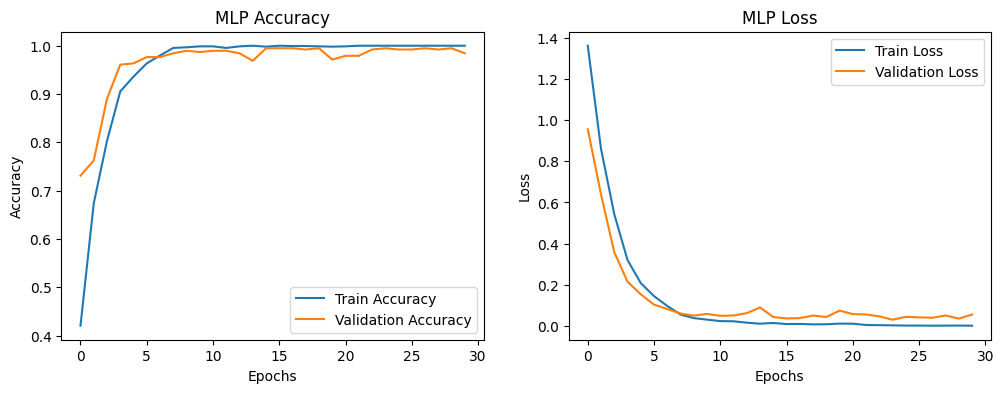

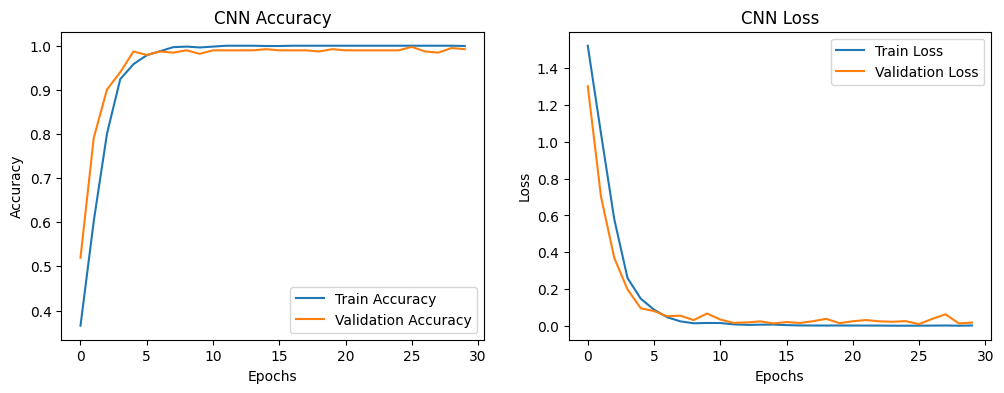

In [ ]:
plot_performance(mlp_history, 'MLP')
plot_performance(cnn_history, 'CNN')
#plot_performance(cnn_lstm_history, 'CNN+LSTM')
#plot_performance(lstm_history, 'LSTM')


In [ ]:
# Évaluation des modèles
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test.reshape(X_test.shape[0], -1, 1), y_test, verbose=0)
#lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
#cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)

# Affichage des résultats
print(f"MLP Accuracy: {mlp_accuracy:.2f} - Loss: {mlp_loss:.2f}")
print(f"CNN Accuracy: {cnn_accuracy:.2f} - Loss: {cnn_loss:.2f}")
#print(f"LSTM Accuracy: {lstm_accuracy:.2f} - Loss: {lstm_loss:.2f}")
#print(f"CNN_LSTM Accuracy: {cnn_lstm_accuracy:.2f} - Loss: {cnn_lstm_loss:.2f}")


MLP Accuracy: 0.98 - Loss: 0.06
CNN Accuracy: 0.99 - Loss: 0.02


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Reshape

def predict_audio_class(file_path, model, label_map, sample_rate=22050, n_mfcc=40, max_pad_length=100):
    """
    Prédit la classe d'un fichier audio en utilisant le modèle CNN.

    Args:
        file_path (str): Chemin vers le fichier audio à tester
        model: Modèle Keras entraîné
        label_map (dict): Dictionnaire de mapping des labels
        sample_rate (int): Fréquence d'échantillonnage
        n_mfcc (int): Nombre de coefficients MFCC à extraire
        max_pad_length (int): Longueur maximale pour le padding

    Returns:
        tuple: (classe prédite, probabilités par classe)
    """
    # Extraire les MFCC
    mfcc = extract_mfcc(file_path, max_pad_length)
    if mfcc is None:
        return None, None

    # Redimensionner pour le modèle (ajout de la dimension channel)
    mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1], 1)

    # Normalisation
    mfcc = mfcc.astype('float32') / np.max(mfcc)

    # Redimensionner pour le CNN
    mfcc = np.reshape(mfcc, (mfcc.shape[0], -1))

    # Prédiction
    predictions = model.predict(mfcc)
    predicted_class_idx = np.argmax(predictions[0])

    # Trouver le nom de la classe correspondante
    predicted_class = [k for k, v in label_map.items() if v == predicted_class_idx][0]

    # Créer un dictionnaire des probabilités par classe
    class_probabilities = {class_name: float(prob)
                          for class_name, prob in zip(label_map.keys(), predictions[0])}

    return predicted_class, class_probabilities



In [ ]:
# Exemple d'utilisation:
predicted_class, probabilities = predict_audio_class("bur1.wav", cnn_model, label_map)
print(f"Classe prédite: {predicted_class}")
print(f"Probabilités: {probabilities}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Classe prédite: burping
Probabilités: {'tired': 1.4220613805303794e-16, 'burping': 1.0, 'hungry': 3.631451761521021e-08, 'belly_pain': 3.032013049376718e-14, 'discomfort': 3.2690058694087446e-16}


In [ ]:
# Sauvegarde du modèle complet (architecture + poids + compile info)
cnn_model.save('cnn_model.h5')


In [ ]:
from google.colab import files
files.download('cnn_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>